In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('iir_podatkovna_zbirka.xlsx')
df

,Unnamed: 0,time,global energy,diffusive energy,mean T,min T,max T,T,precipitation,mean pressure,min pressure,max pressure,mean rel. hum.,min rel. hum.,max rel. hum.,rel. hum.,wind speed,wind direction,max gust
0,0,2019-03-20 19:30:00,0.0,0.0,3.1,3.0,3.3,3.2,0.0,953.0,953.0,953.0,50.0,49.0,51.0,50.0,2.8,40.0,5.1
1,1,2022-04-16 15:50:00,NaN,NaN,9.4,9.2,9.6,9.2,NaN,942.0,942.0,943.0,63.0,61.0,66.0,62.0,3.1,29.0,6.3
2,2,2017-01-29 02:00:00,0.0,0.0,-7.4,-8.1,-7.0,-7.1,0.0,944.0,944.0,944.0,94.0,92.0,97.0,95.0,1.0,190.0,1.5
3,3,2021-10-09 07:20:00,NaN,NaN,5.4,5.3,5.6,5.6,NaN,946.0,946.0,947.0,81.0,80.0,83.0,80.0,5.4,47.0,8.6
4,4,2019-11-15 06:20:00,NaN,NaN,3.9,3.9,4.0,3.9,NaN,931.0,931.0,931.0,98.0,97.0,99.0,98.0,2.7,11.0,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311035,311035,2022-09-13 22:00:00,0.0,0.0,16.3,16.2,16.4,16.2,0.0,936.0,936.0,936.0,86.0,85.0,86.0,86.0,4.6,201.0,7.2
311036,311036,2019-09-20 17:40:00,NaN,NaN,11.3,11.3,11.4,11.3,NaN,948.0,948.0,948.0,59.0,57.0,61.0,59.0,1.5,56.0,2.5
311037,311037,2022-08-28 12:30:00,528.0,299.0,23.0,22.8,23.2,22.9,0.0,938.0,938.0,938.0,61.0,56.0,66.0,63.0,2.0,193.0,3.3
311038,311038,2021-03-06 22:40:00,NaN,NaN,-1.6,-1.7,-1.5,-1.7,NaN,950.0,950.0,950.0,48.0,48.0,48.0,48.0,0.6,320.0,1.0


In [3]:
df['time'] = pd.to_datetime(df['time'])
df.sort_values(by='time', inplace=True)
df = df.drop(['time'], axis=1)

In [4]:
imputer = IterativeImputer()
imputer.fit(df)
df_imputed = imputer.transform(df)
df = pd.DataFrame(df_imputed, columns=df.columns)

In [5]:
X = df.drop(['global energy'], axis=1)
Y = df['global energy'].to_numpy()

In [6]:
mi = mutual_info_regression(X, Y)
selected_features = X.columns[np.argsort(mi)[-5:]]
print(selected_features)
X = X[selected_features]

Index(['mean rel. hum.', 'rel. hum.', 'min rel. hum.', 'precipitation',
       'diffusive energy'],
      dtype='object')


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=4032, shuffle=False)

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
n_future = 1
n_past = 504

X_train_temp = []
Y_train_temp = []
X_test_temp = []
Y_test_temp = []

for i in range(n_past, len(X_train) - n_future + 1):
    X_train_temp.append(X_train[i - n_past:i, :])
    Y_train_temp.append(Y_train[i + n_future - 1:i + n_future])

for i in range(n_past, len(X_test) - n_future + 1):
    X_test_temp.append(X_test[i - n_past:i, :])
    Y_test_temp.append(Y_test[i + n_future - 1:i + n_future])

X_train = np.array(X_train_temp)
Y_train = np.array(Y_train_temp)
X_test = np.array(X_test_temp)
Y_test = np.array(Y_test_temp)

In [10]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model = Sequential()
model.add(LSTM(128, input_shape=(504, 5), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[1]))

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [16]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 504, 128)          68608     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train, Y_train, epochs=20, steps_per_epoch=500, validation_data=(X_test, Y_test), batch_size=64) #,
#                    callbacks=[early_stopping])

model.save('model.h5')

Epoch 1/20
500/500 [==============================] - 498s 976ms/step - loss: 53364.3086 - val_loss: 8886.5518
Epoch 2/20
500/500 [==============================] - 481s 962ms/step - loss: 47287.1328 - val_loss: 9937.4102
Epoch 3/20
500/500 [==============================] - 482s 964ms/step - loss: 43605.8711 - val_loss: 11929.3281
Epoch 4/20
500/500 [==============================] - 486s 973ms/step - loss: 41379.6914 - val_loss: 14404.7236
Epoch 5/20
500/500 [==============================] - 486s 973ms/step - loss: 39291.0898 - val_loss: 16745.0234
Epoch 6/20
500/500 [==============================] - 489s 979ms/step - loss: 38949.2578 - val_loss: 18667.0723
Epoch 7/20
500/500 [==============================] - 495s 989ms/step - loss: 38203.6719 - val_loss: 20043.8730
Epoch 8/20
500/500 [==============================] - 500s 1000ms/step - loss: 33162.6133 - val_loss: 4559.2163
Epoch 9/20
500/500 [==============================] - 495s 990ms/step - loss: 25337.8008 - val_loss: 3763.

111/111 [==============================] - 18s 154ms/step
Test loss: 3266.76708984375
Mean Absolute Error: 37.00640145712454
Mean Squared Error: 3266.767179163756
Explained Variance Score: 0.6581709125214004


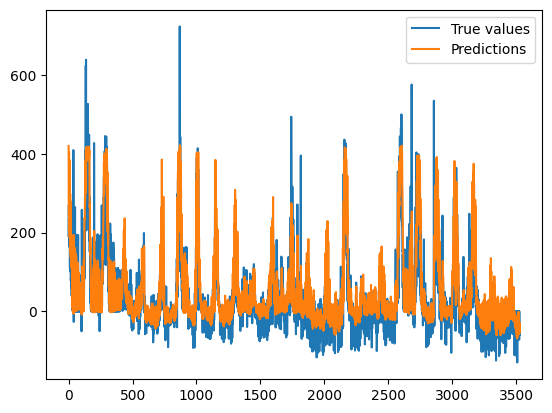

In [13]:
predictions = model.predict(X_test)
result = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test loss: {result}")

mae = mean_absolute_error(Y_test, predictions)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(Y_test, predictions)
print(f"Mean Squared Error: {mse}")

evs = explained_variance_score(Y_test, predictions)
print(f"Explained Variance Score: {evs}")

plt.plot(Y_test, label='True values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

# 10 znacilnic

In [5]:
X = df.drop(['global energy'], axis=1)
Y = df['global energy'].to_numpy()

mi = mutual_info_regression(X, Y)
selected_features = X.columns[np.argsort(mi)[-10:]]
print(selected_features)
X = X[selected_features]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=4032, shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Index(['min T', 'mean T', 'T', 'max T', 'max rel. hum.', 'mean rel. hum.',
       'rel. hum.', 'min rel. hum.', 'precipitation', 'diffusive energy'],
      dtype='object')


In [6]:
n_future = 1
n_past = 504

X_train_temp = []
Y_train_temp = []
X_test_temp = []
Y_test_temp = []

for i in range(n_past, len(X_train) - n_future + 1):
    X_train_temp.append(X_train[i - n_past:i, :])
    Y_train_temp.append(Y_train[i + n_future - 1:i + n_future])

for i in range(n_past, len(X_test) - n_future + 1):
    X_test_temp.append(X_test[i - n_past:i, :])
    Y_test_temp.append(Y_test[i + n_future - 1:i + n_future])

X_train = np.array(X_train_temp)
Y_train = np.array(Y_train_temp)
X_test = np.array(X_test_temp)
Y_test = np.array(Y_test_temp)

In [7]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model2 = Sequential()
model2.add(LSTM(128, input_shape=(504, 10), return_sequences=True))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(Y_train.shape[1]))

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

cp = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(optimizer='adam', loss='mse')
model2.summary()

history2 = model2.fit(X_train, Y_train, epochs=20, steps_per_epoch=500, validation_data=(X_test, Y_test), batch_size=64,callbacks=[cp])

model2 = load_model('model2/')

model2.save('model2.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 504, 128)          71168     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 120,641
Trainable params: 120,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 53860.0195

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 561s 1s/step - loss: 53860.0195 - val_loss: 8891.5947
Epoch 2/20
500/500 [==============================] - 486s 971ms/step - loss: 47269.7383 - val_loss: 9942.3408
Epoch 3/20
500/500 [==============================] - 472s 943ms/step - loss: 42844.1992 - val_loss: 12022.0645
Epoch 4/20
500/500 [==============================] - 471s 943ms/step - loss: 40357.0195 - val_loss: 14385.9932
Epoch 5/20
500/500 [==============================] - 486s 971ms/step - loss: 39273.2266 - val_loss: 16755.7930
Epoch 6/20
500/500 [==============================] - ETA: 0s - loss: 35636.4141

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 490s 981ms/step - loss: 35636.4141 - val_loss: 4421.9507
Epoch 7/20
500/500 [==============================] - ETA: 0s - loss: 26872.4297

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 574s 1s/step - loss: 26872.4297 - val_loss: 3716.5981
Epoch 8/20
500/500 [==============================] - ETA: 0s - loss: 23088.4785

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 533s 1s/step - loss: 23088.4785 - val_loss: 3416.3340
Epoch 9/20
500/500 [==============================] - ETA: 0s - loss: 20442.2832

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 606s 1s/step - loss: 20442.2832 - val_loss: 3379.9187
Epoch 10/20
500/500 [==============================] - ETA: 0s - loss: 18785.9531

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 614s 1s/step - loss: 18785.9531 - val_loss: 3091.9150
Epoch 11/20
500/500 [==============================] - ETA: 0s - loss: 16758.9199

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 621s 1s/step - loss: 16758.9199 - val_loss: 2893.8264
Epoch 12/20
500/500 [==============================] - ETA: 0s - loss: 15049.5527

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 632s 1s/step - loss: 15049.5527 - val_loss: 2823.9255
Epoch 13/20
500/500 [==============================] - 650s 1s/step - loss: 13602.4502 - val_loss: 2979.5813
Epoch 14/20
500/500 [==============================] - 652s 1s/step - loss: 12778.9082 - val_loss: 2835.8496
Epoch 15/20
500/500 [==============================] - ETA: 0s - loss: 11313.6650

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 648s 1s/step - loss: 11313.6650 - val_loss: 2754.8596
Epoch 16/20
500/500 [==============================] - 680s 1s/step - loss: 10833.8291 - val_loss: 2834.4214
Epoch 17/20
500/500 [==============================] - ETA: 0s - loss: 10393.5596

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 699s 1s/step - loss: 10393.5596 - val_loss: 2710.0540
Epoch 18/20
500/500 [==============================] - ETA: 0s - loss: 9102.6885

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 775s 2s/step - loss: 9102.6885 - val_loss: 2510.2542
Epoch 19/20
500/500 [==============================] - ETA: 0s - loss: 8991.2109

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


500/500 [==============================] - 764s 2s/step - loss: 8991.2109 - val_loss: 2454.1675
Epoch 20/20
500/500 [==============================] - 842s 2s/step - loss: 8579.1865 - val_loss: 2595.7097


111/111 [==============================] - 30s 247ms/step
Test loss: 2454.1669921875
Mean Absolute Error: 30.367249250010122
Mean Squared Error: 2454.167461868445
Explained Variance Score: 0.7242912669022957


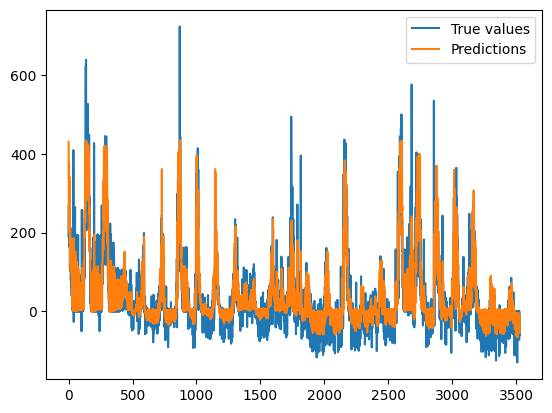

In [9]:
predictions2 = model2.predict(X_test)
result2 = model2.evaluate(X_test, Y_test, verbose=0)
print(f"Test loss: {result2}")

mae2 = mean_absolute_error(Y_test, predictions2)
print(f"Mean Absolute Error: {mae2}")

mse2 = mean_squared_error(Y_test, predictions2)
print(f"Mean Squared Error: {mse2}")

evs2 = explained_variance_score(Y_test, predictions2)
print(f"Explained Variance Score: {evs2}")

plt.plot(Y_test, label='True values')
plt.plot(predictions2, label='Predictions')
plt.legend()
plt.show()

In [ ]:
# z 1008 zaporednih

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt

df = pd.read_excel('iir_podatkovna_zbirka.xlsx')

df['time'] = pd.to_datetime(df['time'])
df.sort_values(by='time', inplace=True)
df = df.drop(['time'], axis=1)

imputer = IterativeImputer()
imputer.fit(df)
df_imputed = imputer.transform(df)
df = pd.DataFrame(df_imputed, columns=df.columns)

In [3]:
X = df.drop(['global energy'], axis=1)
Y = df['global energy'].to_numpy()

mi = mutual_info_regression(X, Y)
selected_features = X.columns[np.argsort(mi)[-5:]]
print(selected_features)
X = X[selected_features]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=4032, shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Index(['mean rel. hum.', 'rel. hum.', 'min rel. hum.', 'precipitation',
       'diffusive energy'],
      dtype='object')


In [4]:
n_future = 1
n_past = 1008

X_train_temp = []
Y_train_temp = []
X_test_temp = []
Y_test_temp = []

for i in range(n_past, len(X_train) - n_future + 1):
    X_train_temp.append(X_train[i - n_past:i, :])
    Y_train_temp.append(Y_train[i + n_future - 1:i + n_future])

for i in range(n_past, len(X_test) - n_future + 1):
    X_test_temp.append(X_test[i - n_past:i, :])
    Y_test_temp.append(Y_test[i + n_future - 1:i + n_future])

X_train = np.array(X_train_temp)
Y_train = np.array(Y_train_temp)
X_test = np.array(X_test_temp)
Y_test = np.array(Y_test_temp)

In [5]:
model3 = Sequential()
model3.add(LSTM(128, input_shape=(1008, 5), return_sequences=True))
model3.add(LSTM(64, return_sequences=False))
model3.add(Dropout(0.2))
model3.add(Dense(Y_train.shape[1]))

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

cp = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(optimizer='adam', loss='mse')
model3.summary()

history3 = model3.fit(X_train, Y_train, epochs=20, steps_per_epoch=500, validation_data=(X_test, Y_test), batch_size=64,callbacks=[cp])

model3 = load_model('model3/')

model3.save('model3.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1008, 128)         68608     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 54529.7695

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 1518s 3s/step - loss: 54529.7695 - val_loss: 7491.9814
Epoch 2/20
500/500 [==============================] - 1543s 3s/step - loss: 46853.3516 - val_loss: 9093.2754
Epoch 3/20
500/500 [==============================] - 1529s 3s/step - loss: 43056.0234 - val_loss: 11636.8613
Epoch 4/20
500/500 [==============================] - 1511s 3s/step - loss: 40392.1250 - val_loss: 14513.4287
Epoch 5/20
500/500 [==============================] - 1524s 3s/step - loss: 38089.4844 - val_loss: 16961.4727
Epoch 6/20
500/500 [==============================] - 1533s 3s/step - loss: 39656.3477 - val_loss: 19303.5020
Epoch 7/20
500/500 [==============================] - ETA: 0s - loss: 34735.9375

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 1548s 3s/step - loss: 34735.9375 - val_loss: 3764.4150
Epoch 8/20
500/500 [==============================] - ETA: 0s - loss: 27297.4082

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 1563s 3s/step - loss: 27297.4082 - val_loss: 3763.2136
Epoch 9/20
500/500 [==============================] - ETA: 0s - loss: 23723.4199

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 1903s 4s/step - loss: 23723.4199 - val_loss: 3230.7119
Epoch 10/20
500/500 [==============================] - ETA: 0s - loss: 20984.5078

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 2368s 5s/step - loss: 20984.5078 - val_loss: 3205.8545
Epoch 11/20
500/500 [==============================] - ETA: 0s - loss: 17599.0820

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 2222s 4s/step - loss: 17599.0820 - val_loss: 2946.0774
Epoch 12/20
500/500 [==============================] - ETA: 0s - loss: 16485.9414

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 2584s 5s/step - loss: 16485.9414 - val_loss: 2926.2063
Epoch 13/20
500/500 [==============================] - ETA: 0s - loss: 15117.8486

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 2237s 4s/step - loss: 15117.8486 - val_loss: 2762.9397
Epoch 14/20
500/500 [==============================] - 2530s 5s/step - loss: 14070.6592 - val_loss: 2892.4919
Epoch 15/20
500/500 [==============================] - ETA: 0s - loss: 12882.1748

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 2558s 5s/step - loss: 12882.1748 - val_loss: 2672.2329
Epoch 16/20
500/500 [==============================] - 2575s 5s/step - loss: 12184.7754 - val_loss: 2809.7246
Epoch 17/20
500/500 [==============================] - ETA: 0s - loss: 11355.8311

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 2581s 5s/step - loss: 11355.8311 - val_loss: 2648.0740
Epoch 18/20
500/500 [==============================] - ETA: 0s - loss: 10552.1543

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 2901s 6s/step - loss: 10552.1543 - val_loss: 2562.2205
Epoch 19/20
500/500 [==============================] - ETA: 0s - loss: 9726.1719

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


500/500 [==============================] - 2698s 5s/step - loss: 9726.1719 - val_loss: 2560.9656
Epoch 20/20
500/500 [==============================] - 2681s 5s/step - loss: 9451.1416 - val_loss: 2637.2012


95/95 [==============================] - 34s 333ms/step
Test loss: 2560.9658203125
Mean Absolute Error: 32.1306613812626
Mean Squared Error: 2560.9656014239763
Explained Variance Score: 0.6431708865463263


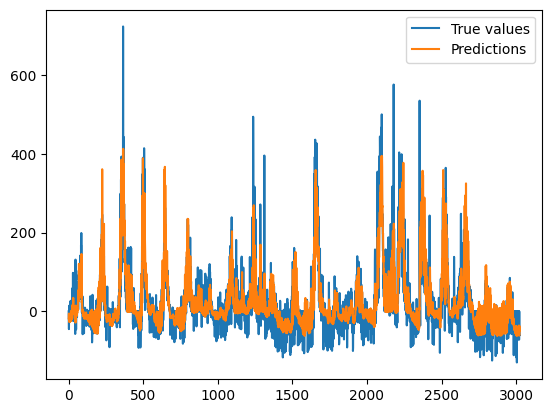

In [7]:
predictions3 = model3.predict(X_test)
result3 = model3.evaluate(X_test, Y_test, verbose=0)
print(f"Test loss: {result3}")

mae3 = mean_absolute_error(Y_test, predictions3)
print(f"Mean Absolute Error: {mae3}")

mse3 = mean_squared_error(Y_test, predictions3)
print(f"Mean Squared Error: {mse3}")

evs3 = explained_variance_score(Y_test, predictions3)
print(f"Explained Variance Score: {evs3}")

plt.plot(Y_test, label='True values')
plt.plot(predictions3, label='Predictions')
plt.legend()
plt.show()